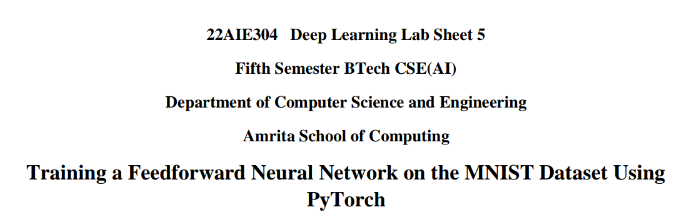

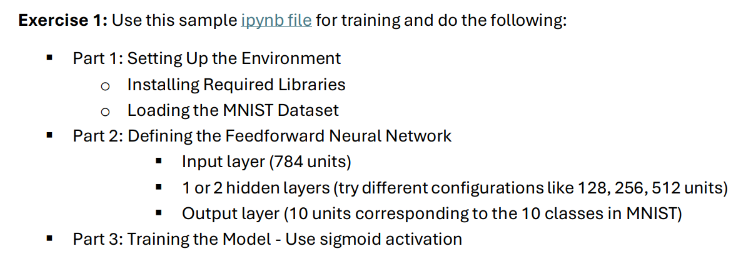

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16118377.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 485601.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4377589.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 7632423.38it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(FeedforwardNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

model = FeedforwardNN(hidden_size=128)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 5
for epoch in range(n_epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(trainloader):.4f}')

Epoch [1/5], Loss: 0.1062
Epoch [2/5], Loss: 0.1047
Epoch [3/5], Loss: 0.1040
Epoch [4/5], Loss: 0.1035
Epoch [5/5], Loss: 0.1032


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy for 10,000 data ppoints: {100 * correct / total} %')


Accuracy for 10,000 data ppoints: 96.31 %


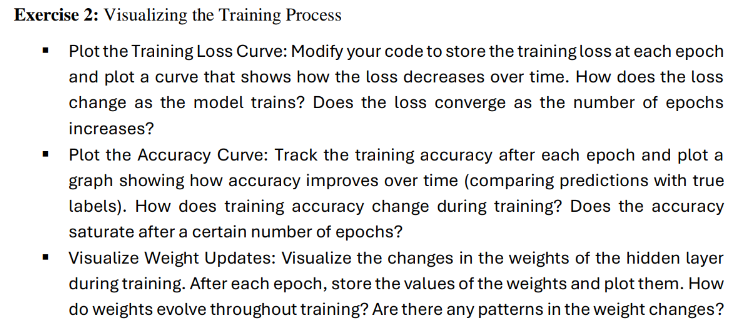

In [ ]:
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values for visualization
train_loss_history = []
train_accuracy_history = []

# Modify the training loop
n_epochs = 5  # Adjust the number of epochs as needed
for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store average loss and accuracy for each epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total
    train_loss_history.append(avg_loss)
    train_accuracy_history.append(accuracy)

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/5], Loss: 0.1030, Accuracy: 97.10%
Epoch [2/5], Loss: 0.1030, Accuracy: 97.10%
Epoch [3/5], Loss: 0.1028, Accuracy: 97.11%
Epoch [4/5], Loss: 0.1027, Accuracy: 97.11%
Epoch [5/5], Loss: 0.1026, Accuracy: 97.11%


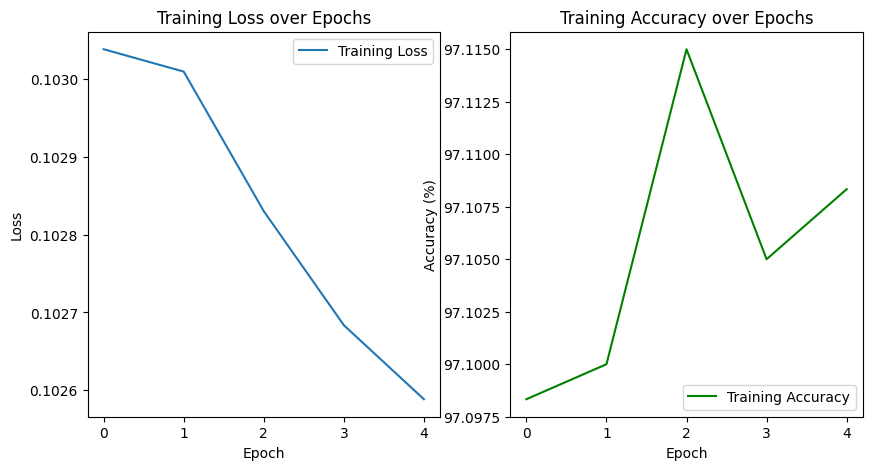

In [ ]:
# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Epoch [1/5], Loss: 0.1025, Accuracy: 97.12%
Epoch [2/5], Loss: 0.1024, Accuracy: 97.11%
Epoch [3/5], Loss: 0.1024, Accuracy: 97.12%
Epoch [4/5], Loss: 0.1023, Accuracy: 97.13%
Epoch [5/5], Loss: 0.1022, Accuracy: 97.14%


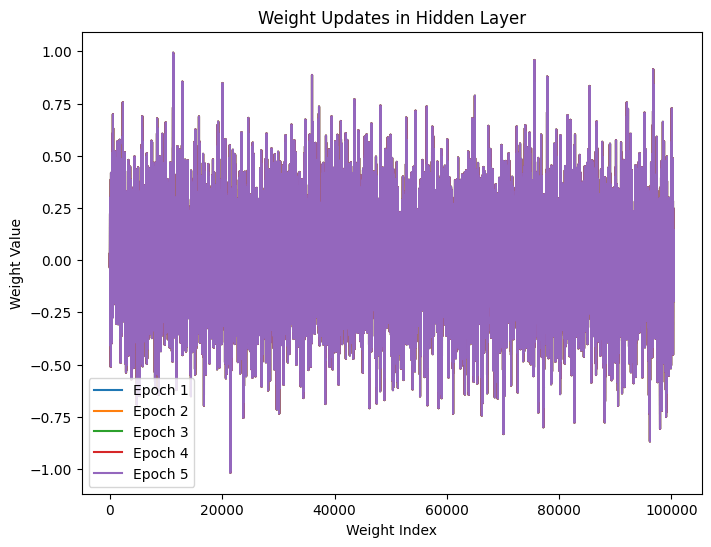

In [ ]:
# Store the weights of the hidden layer after each epoch
hidden_weights_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct / total
    train_loss_history.append(avg_loss)
    train_accuracy_history.append(accuracy)

    # Store the hidden layer weights after each epoch
    hidden_weights_history.append(model.fc1.weight.data.clone())

    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Visualize the changes in the weights of the hidden layer
plt.figure(figsize=(8, 6))
for i in range(n_epochs):
    plt.plot(hidden_weights_history[i].view(-1).cpu().numpy(), label=f'Epoch {i+1}')

plt.title('Weight Updates in Hidden Layer')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()
